In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bidict import bidict
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [32]:
ENCODER = bidict({
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6,
    'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12,
    'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18,
    'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24,
    'Y': 25, 'Z': 26
})

In [33]:
labels = np.load('../data/labels.npy')
labels = np.array([ENCODER[x] for x in labels])
labels.shape

(274,)

In [34]:
imgs = np.load('../data/images.npy')
imgs = imgs.astype("float32") / 255
imgs.shape

(274, 50, 50)

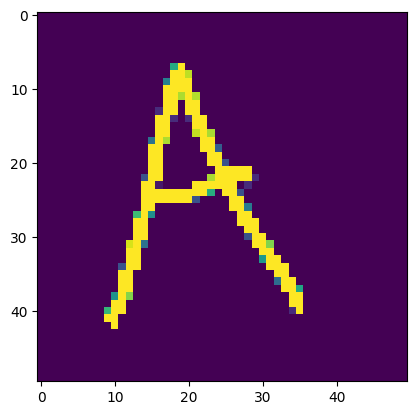

In [35]:
plt.figure()
plt.imshow(imgs[0])
plt.grid(False)
plt.show()

In [36]:
imgs = np.expand_dims(imgs, -1)

In [37]:
labels, imgs = shuffle(labels, imgs)
split = .75

labels_train = labels[:int(len(labels) * split)]
labels_test = labels[int(len(labels) * split):]

imgs_train = imgs[:int(len(imgs) * split)]
imgs_test = imgs[int(len(imgs) * split):]

In [38]:
batch_size = 16
epochs = 20

model = keras.Sequential([
    keras.Input(shape=(50, 50, 1)),
    layers.Conv2D(256, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(512, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(1024, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(len(ENCODER)+1, activation='softmax')
])

In [39]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
optimizer = keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [40]:
model.fit(imgs_train,
          labels_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(imgs_test, labels_test),
          callbacks=[early_stopping])

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.0311 - loss: 3.6272 - val_accuracy: 0.1739 - val_loss: 3.2799
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2435 - loss: 3.2385 - val_accuracy: 0.2319 - val_loss: 2.9506
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.4081 - loss: 2.4527 - val_accuracy: 0.6232 - val_loss: 1.1703
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7320 - loss: 0.8370 - val_accuracy: 0.7536 - val_loss: 0.4570
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.8677 - loss: 0.3298 - val_accuracy: 0.9565 - val_loss: 0.2435
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9734 - loss: 0.1060 - val_accuracy: 0.9130 - val_loss: 0.2846
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9523 - loss: 0.1164 - val_accuracy: 0.9420 - val_loss: 0.2103


In [41]:
labels_pred = np.argmax(model.predict(imgs_test), axis=-1)

2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step WARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C4B1AFFBA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [42]:
cm = confusion_matrix(labels_test, labels_pred, labels=list(ENCODER.inverse.keys()))

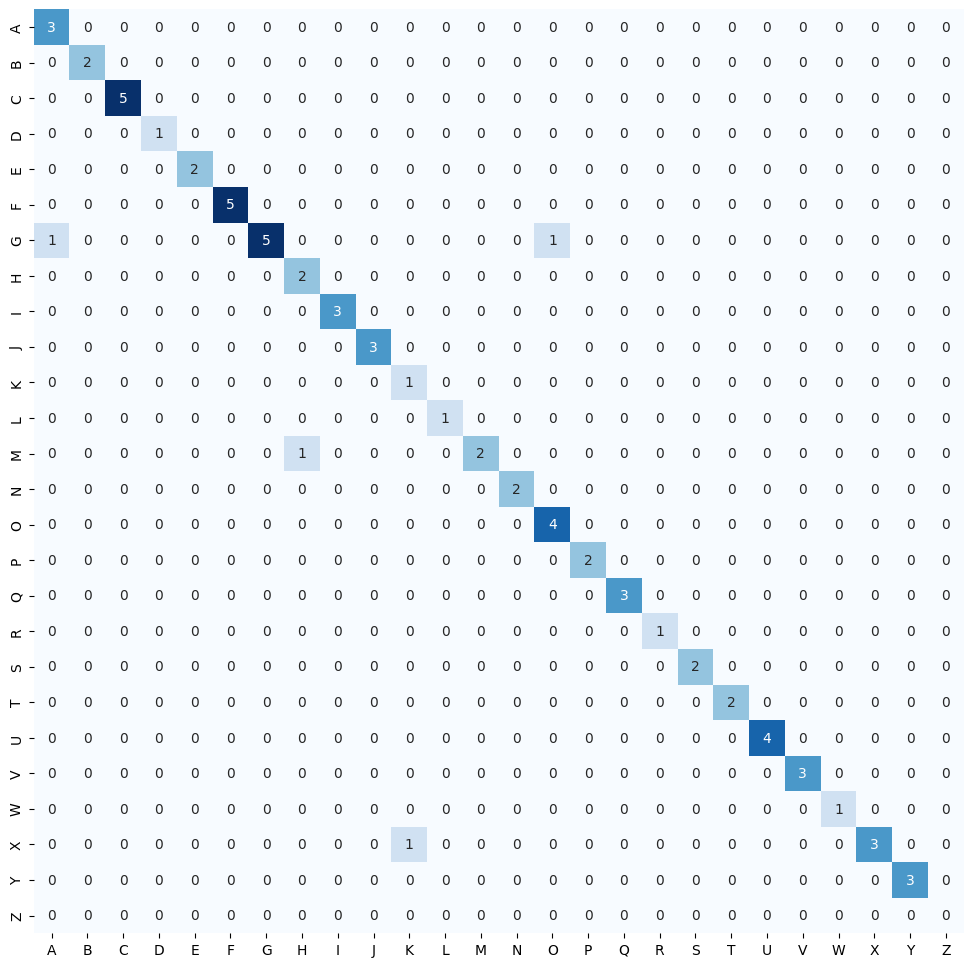

In [43]:
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, cbar=False, cmap="Blues", xticklabels=list(ENCODER.keys()), yticklabels=list(ENCODER.keys()))
plt.show()

In [44]:
model.save('../letter.keras')